In [9]:
# from importlib import reload
import gnn_tracking_hpo
from gnn_tracking.utils.timing import timing
# reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path, get_config, find_checkpoints

add_scripts_path()
import copy

from tune_fixed_ec import PretrainedECTrainable

In [10]:
PretrainedECTrainable._device = "cpu"

In [11]:
project = "fixed-ec-b7b3f0d4"
hash = "1503094f"

In [12]:
config = get_config(project, hash)
config["n_graphs_train"] = 1
config["n_graphs_val"] = 10
config["n_graphs_test"] = 1
config["m_mask_orphan_nodes"] = True
# config["m_ec_threshold"] = 0.0

[20:38:37 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-b7b3f0d4/PretrainedECTrainable_1503094f_6_attr_pt_thld=0.7040,batch_size=5,ec_hash=b7b3f0d4,ec_project=ec,ec_pt_thld=0.0000,gnn_tracking_ex_2023-01-26_12-57-40/params.json


In [13]:
trainable = PretrainedECTrainable(config)
trainable.load_checkpoint(find_checkpoints(project, hash)[-1], device="cpu")

[20:38:38 gnnt_hpo] INFO: Initializing pre-trained EC
[20:38:38 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_b7b3f0d4_38_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=50f90c1_2023-01-24_03-06-50/params.json
[20:38:38 gnnt_hpo] INFO: I'm running on a node with job ID=45232552
[20:38:38 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[20:38:38 gnnt_hpo] INFO: The ID of my dispatcher is 0
[20:38:38 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[20:38:38 gnnt_hpo] DEBUG: Got config
{'batch_size': 5,
 'ec_pt_thld': 0.7710612479097784,
 'focal_alpha': 0.3824243521658318,
 'focal_gamma': 2.5581270116033084,
 'gnn_tracking_experiments_hash': '50f90c1b6d806c3bce012abda77e6310b3423f41',
 'gnn_tracking_hash': '525e92fe1359fbff371f73c405c37b6d6ec22b32',
 'lr': 0.0004929040972127238,
 'lw_edge': 1.0,


In [14]:
config_nop = copy.deepcopy(config)
config_nop["m_mask_orphan_nodes"] = False
trainable_nop = PretrainedECTrainable(config_nop)
trainable_nop.load_checkpoint(find_checkpoints(project, hash)[-1], device="cpu")

[20:38:38 gnnt_hpo] INFO: Initializing pre-trained EC
[20:38:38 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_b7b3f0d4_38_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=50f90c1_2023-01-24_03-06-50/params.json
[20:38:38 gnnt_hpo] INFO: I'm running on a node with job ID=45232552
[20:38:38 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[20:38:38 gnnt_hpo] INFO: The ID of my dispatcher is 0
[20:38:38 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[20:38:38 gnnt_hpo] DEBUG: Got config
{'batch_size': 5,
 'ec_pt_thld': 0.7710612479097784,
 'focal_alpha': 0.3824243521658318,
 'focal_gamma': 2.5581270116033084,
 'gnn_tracking_experiments_hash': '50f90c1b6d806c3bce012abda77e6310b3423f41',
 'gnn_tracking_hash': '525e92fe1359fbff371f73c405c37b6d6ec22b32',
 'lr': 0.0004929040972127238,
 'lw_edge': 1.0,


In [15]:
trainable.trainer.test_step()

DEBUG: Masked 7545, remaining 3955 hits
DEBUG: Edge attr avg: tensor([-3.1287e-04,  1.7662e-06, -1.5425e-04,  8.8237e-02])
DEBUG: s avg: tensor([ 0.0863, -0.0156,  0.0078,  0.0553,  1.3236,  0.6598])
DEBUG: h hc avg: tensor([5.0181, 3.6730, 4.0519, 3.9811, 0.0000])
DEBUG: edge_attr_hc avg: tensor([0.0000, 0.0000, 0.8103, 0.0000, 0.6750])
DEBUG: h_hc avg: tensor([ 0.0000, 10.4060, 35.9823, 78.8948,  0.0000])
DEBUG: beta avg: tensor([0.])
DEBUG: h avg: tensor([-103.2919,  -18.0160,  -17.5819,  -33.4649,   55.9700,   -1.5552])
DEBUG: Masked 7006, remaining 3401 hits
DEBUG: Edge attr avg: tensor([-2.8172e-04, -1.6150e-05,  2.8405e-04,  8.5149e-02])
DEBUG: s avg: tensor([ 0.0869, -0.2367,  0.0179,  0.0809, -0.5953, -8.2320])
DEBUG: h hc avg: tensor([4.9601, 3.1586, 4.0694, 4.3870, 0.0000])
DEBUG: edge_attr_hc avg: tensor([0.0000, 0.0000, 0.7881, 0.0000, 0.6773])
DEBUG: h_hc avg: tensor([ 0.0000,  9.9724, 34.1107, 75.0842,  0.0000])
DEBUG: beta avg: tensor([0.])
DEBUG: h avg: tensor([-98.268

{'acc_pt0.9': 0.9947214079052653,
 'TPR_pt0.9': 0.9215764015127771,
 'TNR_pt0.9': 0.9962296618556217,
 'FPR_pt0.9': 0.00377033814437824,
 'FNR_pt0.9': 0.07842359848722288,
 'balanced_acc_pt0.9': 0.9589030316841994,
 'F1_pt0.9': 0.8769033458164444,
 'MCC_pt0.9': 0.8752872783714931,
 'max_ba_pt0.9': 0.9806977732562341,
 'max_ba_loc_pt0.9': 0.1532663255929947,
 'max_f1_pt0.9': 0.9032994018392384,
 'max_f1_loc_pt0.9': 0.37437185645103455,
 'max_mcc_pt0.9': 0.9018436321966036,
 'max_mcc_loc_pt0.9': 0.37437185645103455,
 'tpr_eq_tnr_pt0.9': 0.9803093832443942,
 'tpr_eq_tnr_loc_pt0.9': 0.15075376629829407,
 'roc_auc_pt0.9': 0.9983195317149429,
 'roc_auc_0.001FPR_pt0.9': 0.8836367357009103,
 'roc_auc_0.01FPR_pt0.9': 0.9568880792004328,
 'roc_auc_0.1FPR_pt0.9': 0.9915329829174191,
 'acc_pt1.5': 0.9933798805398284,
 'TPR_pt1.5': 0.8894490754585327,
 'TNR_pt1.5': 0.9955190080011831,
 'FPR_pt1.5': 0.004480991998816917,
 'FNR_pt1.5': 0.11055092454146731,
 'balanced_acc_pt1.5': 0.9424840417298579,
 

In [16]:
trainable_nop.trainer.test_step()

/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
DEBUG: Edge attr avg: tensor([-3.1287e-04,  1.7662e-06, -1.5425e-04,  8.8237e-02])
DEBUG: s avg: tensor([ 0.0864, -0.0505, -0.0136, -0.0398,  1.8792, -0.1429])
DEBUG: h hc avg: tensor([5.0529, 3.6429, 4.1297, 3.9499, 0.0000])
DEBUG: edge_attr_hc avg: tensor([0.0000, 0.0000, 0.8103, 0.0000, 0.6750])
DEBUG: h_hc avg: tensor([ 0.0000, 10.7723, 70.2362, 52.7136,  0.0000])
DEBUG: beta avg: tensor([0.])
DEBUG: h avg: tensor([-103.5836,  -18.7261,  -18.0800,  -34.9497,   56.8636,   -1.9524])
DEBU

{'acc_pt0.9': 0.9947214079052653,
 'TPR_pt0.9': 0.9215764015127771,
 'TNR_pt0.9': 0.9962296618556217,
 'FPR_pt0.9': 0.00377033814437824,
 'FNR_pt0.9': 0.07842359848722288,
 'balanced_acc_pt0.9': 0.9589030316841994,
 'F1_pt0.9': 0.8769033458164444,
 'MCC_pt0.9': 0.8752872783714931,
 'max_ba_pt0.9': 0.9806977732562341,
 'max_ba_loc_pt0.9': 0.1532663255929947,
 'max_f1_pt0.9': 0.9032994018392384,
 'max_f1_loc_pt0.9': 0.37437185645103455,
 'max_mcc_pt0.9': 0.9018436321966036,
 'max_mcc_loc_pt0.9': 0.37437185645103455,
 'tpr_eq_tnr_pt0.9': 0.9803093832443942,
 'tpr_eq_tnr_loc_pt0.9': 0.15075376629829407,
 'roc_auc_pt0.9': 0.9983195317149429,
 'roc_auc_0.001FPR_pt0.9': 0.8836367357009103,
 'roc_auc_0.01FPR_pt0.9': 0.9568880792004328,
 'roc_auc_0.1FPR_pt0.9': 0.9915329829174191,
 'acc_pt1.5': 0.9933798805398284,
 'TPR_pt1.5': 0.8894490754585327,
 'TNR_pt1.5': 0.9955190080011831,
 'FPR_pt1.5': 0.004480991998816917,
 'FNR_pt1.5': 0.11055092454146731,
 'balanced_acc_pt1.5': 0.9424840417298579,
 

In [ ]:
import torch

trainer = trainable.trainer
trainer.model.eval()

sel = 1
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

trainer = trainable_nop.trainer
trainer.model.eval()
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output_no_prune = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

In [10]:
mo = model_output
monp = model_output_no_prune

In [11]:
from gnn_tracking.metrics.cluster_metrics import     _tracking_metrics_nan_results

In [12]:
hm = mo["ec_hit_mask"]

In [43]:
hm.sum(),len(hm)

(tensor(10231), 10407)

In [13]:
from gnn_tracking.postprocessing.clusterscanner import OptunaClusterScanResult

In [17]:
def sort_according_to_mask(
    xs: list[np.ndarray], masks: list[np.ndarray] | None = None
) -> list[np.ndarray]:
    """If mask is not `None`, sort vector `x` to first list all elements that are in
    the mask, then all that are masked
    """
    if masks is None:
        masks = [None for _ in xs]

    def inner(x: np.ndarray, mask: np.ndarray | None) -> np.ndarray:
        if mask is None:
            return x
        else:
            return np.concatenate([x[mask], x[~mask]])

    return [inner(x, mask) for x, mask in zip(xs, masks)]

In [ ]:

import pandas as pd
from typing import Iterable
from gnn_tracking.metrics.cluster_metrics import ClusterMetricType, TrackingMetrics
from collections import Counter
from gnn_tracking.utils.math import zero_division_gives_nan
import numpy as np

def tracking_metrics(
    *,
    truth: np.ndarray,
    predicted: np.ndarray,
    pts: np.ndarray,
    reconstructable: np.ndarray,
    pt_thlds: Iterable[float],
    predicted_count_thld=3,
) -> dict[float, TrackingMetrics]:
    """Calculate 'custom' metrics for matching tracks and hits.

    Args:
        truth: Truth labels/PIDs for each hit
        predicted: Predicted labels/cluster index for each hit. Negative labels are
            interpreted as noise (because this is how DBSCAN outputs it) and are
            ignored
        pts: pt values of the hits
        reconstructable: Whether the hit belongs to a "reconstructable tracks" (this
            usually implies a cut on the number of layers that are being hit
            etc.)
        pt_thlds: pt thresholds to calculate the metrics for
        predicted_count_thld: Minimal number of hits in a cluster for it to not be
            rejected.

    Returns:
        See `CustomMetrics`
    """
    assert predicted.shape == truth.shape == pts.shape, (
        predicted.shape,
        truth.shape,
        pts.shape,
    )
    if len(truth) == 0:
        return {pt: _tracking_metrics_nan_results for pt in pt_thlds}
    df = pd.DataFrame({"c": predicted, "id": truth, "pt": pts, "r": reconstructable})

    # For each cluster, we determine the true PID that is associated with the most
    # hits in that cluster.
    # Here we make use of the fact that `df.value_counts` sorts by the count.
    # That means that if we group by the cluster and take the first line
    # for each of the counts, we have the most popular PID for each cluster.
    # The resulting dataframe now has both the most popular PID ("id" column) and the
    # number of times it appears ("0" column).
    # This strategy is a significantly (!) faster version than doing
    # c_id.groupby("c").agg(lambda x: x.mode()[0]) etc.
    pid_counts = df[["c", "id"]].value_counts().reset_index()
    maj_df = pid_counts.groupby("c").first()
    # For each cluster: Which true PID has the most hits?
    c_maj_pids = maj_df["id"]
    # For each cluster: How many hits does the PID with the most hits have?
    c_maj_hits = maj_df[0]
    # Number of hits per cluster
    c_sizes = pid_counts.groupby("c")[0].sum()
    # Assume that negative cluster labels mean that the cluster was labeled as
    # invalid
    unique_predicted, predicted_counts = np.unique(predicted, return_counts=True)
    c_valid_cluster = (unique_predicted >= 0) & (
        predicted_counts >= predicted_count_thld
    )

    # Properties associated to PID. This is pretty trivial, but since everything is
    # passed by, rather than by PID, we need to get rid of "duplicates"
    pid_to_props = df[["id", "pt", "r"]].groupby("id")[["pt", "r"]].first()
    pid_to_pt = pid_to_props["pt"].to_dict()
    pid_to_r = pid_to_props["r"].to_dict()
    # For each cluster: Of which pt is the PID with the most hits?
    c_maj_pts = c_maj_pids.map(pid_to_pt)
    # For each cluster: Is the PID with the most hits reconstructable?
    c_maj_reconstructable = c_maj_pids.map(pid_to_r)

    # For each PID: Number of hits (in any cluster)
    pid_to_count = Counter(truth)
    # For each cluster: Take most popular PID of that cluster and get number of hits of
    # that PID (in any cluster)
    maj_hits = c_maj_pids.map(pid_to_count)

    def r(name, value):
        pass
        # print(name, value.min(), value.mean(), value.max())

    # print(pid_to_count)
    r("c_maj_pids", maj_hits)
    r("maj_hits", maj_hits)

    result = dict[float, ClusterMetricType]()
    for pt in pt_thlds:
        c_mask = (c_maj_pts >= pt) & c_maj_reconstructable

        # For each cluster: Fraction of hits that have the most popular PID
        c_maj_frac = (c_maj_hits[c_mask] / c_sizes[c_mask]).fillna(0)
        # For each cluster: Take the most popular PID of that cluster. What fraction of
        # the corresponding hits is in this cluster?
        maj_frac = (c_maj_hits[c_mask] / maj_hits[c_mask]).fillna(0)

        r("maj > 0.5", maj_frac > 0.5)

        r("c_maj > 0.5", c_maj_frac > 0.5)

        r("a", c_maj_hits[c_mask][c_maj_frac > 0.5])
        r("b", maj_hits[c_mask][c_maj_frac > 0.5])
        r("c", maj_frac[c_maj_frac > 0.5].fillna(0))

        double_majority = np.sum(
            (maj_frac > 0.5) & (c_maj_frac > 0.5) & c_valid_cluster[c_mask]
        ).item()


        h_pt_mask = pts >= pt
        c_pt_mask = c_maj_pts >= pt
        n_particles = len(np.unique(truth[h_pt_mask]))
        n_clusters = len(unique_predicted[c_pt_mask & c_valid_cluster])

        r = {
            "dm_count": double_majority,
            "n_particles": n_particles,
            "n_cleaned_clusters": n_clusters,
            "double_majority": zero_division_gives_nan(double_majority, n_particles),
        }
        result[pt] = r  # type: ignore
    return result  # type: ignore

In [ ]:
def _pad_output_with_noise(labels: np.ndarray, length: int) -> np.ndarray:
    """Pad clustering output to length with noise labels."""
    return np.concatenate([labels, np.full(length - len(labels), -1)])

In [19]:
aco = 0
ico = None
print("Masked", (~hm).sum(), "of", len(hm))

Masked tensor(176) of 10407


In [211]:
cluster_labels = dbscan(mo["x"], eps=0.994)

In [34]:
from gnn_tracking.utils.earlystopping import no_early_stopping
from collections import defaultdict
from typing import Mapping, Callable, Any
from gnn_tracking.utils.log import logger
import optuna
from __future__ import annotations
from gnn_tracking.metrics.cluster_metrics import common_metrics
from gnn_tracking.utils.timing import timing


import numpy as np

from gnn_tracking.postprocessing.clusterscanner import (
    AbstractClusterHyperParamScanner,
    ClusterScanResult, ClusterAlgorithmType,
)


class ClusterHyperParamScanner(AbstractClusterHyperParamScanner):
    def __init__(
        self,
        *,
        algorithm: ClusterAlgorithmType,
        suggest: Callable[[optuna.trial.Trial], dict[str, Any]],
        data: list[np.ndarray],
        truth: list[np.ndarray],
        pts: list[np.ndarray],
        reconstructable: list[np.ndarray],
        guide: str,
        metrics: dict[str, ClusterMetricType],
        sectors: list[np.ndarray] | None = None,
        guide_proxy="",
        early_stopping=no_early_stopping,
        pt_thlds: Iterable[float] = (
            0.0,
            0.5,
            0.9,
            1.5,
        ),
        node_mask: list[np.ndarray] | None = None,
    ):
        self._algorithm = algorithm
        self._suggest = suggest
        self._data: list[np.ndarray] = data
        self._truth: list[np.ndarray] = sort_according_to_mask(truth, node_mask)

        self._pts: list[np.ndarray] = sort_according_to_mask(pts, node_mask)
        self._reconstructable: list[np.ndarray] = sort_according_to_mask(
            reconstructable, node_mask
        )
        self._metrics: dict[str, ClusterMetricType] = metrics
        if sectors is None:
            self._sectors: list[np.ndarray] = [
                np.ones(t, dtype=int) for t in self._truth
            ]
        else:
            assert [len(s) for s in sectors] == [len(t) for t in truth]
            self._sectors = sort_according_to_mask(sectors, node_mask)
        self._es = early_stopping
        self._study = None
        self._cheap_metric = guide_proxy
        self._expensive_metric = guide
        self._graph_to_sector: dict[int, int] = {}
        #: Number of graphs to look at before using accumulated statistics to maybe
        #: prune trial.
        self.pruning_grace_period = 20
        #: Number of trials completed
        self._n_trials_completed = 0
        #: Number of trials that were pruned
        self._n_trials_pruned = 0
        self.pt_thlds = list(pt_thlds)
        if node_mask is None:
            node_mask = [np.full_like(t, True) for t in truth]
        self._node_mask = node_mask

    @staticmethod
    def _pad_output_with_noise(labels: np.ndarray, length: int) -> np.ndarray:
        """Pad clustering output to length with noise labels."""
        if len(labels) > length:
            raise ValueError(len(labels), length)
        return np.concatenate([labels, np.full(length - len(labels), -1)])

    def _get_sector_to_study(self, i_graph: int):
        """Return index of sector to study for graph $i_graph.
        Takes a random one the first time, but then remembers the sector so that we
        get the same one for the same graph.
        """
        try:
            return self._graph_to_sector[i_graph]
        except KeyError:
            pass
        available: list[int] = np.unique(  # type: ignore
            self._sectors[i_graph]
        ).tolist()
        try:
            available.remove(-1)
        except ValueError:
            pass
        choice = np.random.choice(available).item()
        self._graph_to_sector[i_graph] = choice
        return choice

    def _get_explicit_metric(
        self,
        name: str,
        *,
        predicted: np.ndarray,
        truth: np.ndarray,
        pts: np.ndarray,
        reconstructable: np.ndarray,
    ) -> float:
        """Get metric value from dict of metrics."""
        arguments = dict(
            truth=truth,
            predicted=predicted,
            pts=pts,
            reconstructable=reconstructable,
            pt_thlds=self.pt_thlds,
        )
        if "." in name:
            metric, _, subkey = name.partition(".")
            try:
                return self._metrics[metric](**arguments)[subkey]  # type: ignore
            except KeyError:
                pass
        return self._metrics[name](**arguments)  # type: ignore

    def _objective(self, trial: optuna.trial.Trial) -> float:
        """Objective function for optuna."""
        params = self._suggest(trial)
        cheap_foms = []
        all_labels = []
        # Do a first run, looking only at the cheap metric, stopping early
        for i_graph, (data, truth, pts, reconstructable, node_mask) in enumerate(
            zip(
                self._data,
                self._truth,
                self._pts,
                self._reconstructable,
                self._node_mask,
            )
        ):
            # Consider a random sector for each graph, but keep the sector consistent
            # between different trials.
            sector = self._get_sector_to_study(i_graph)
            sector_mask = self._sectors[i_graph] == sector
            data = data[sector_mask[node_mask]]
            truth = truth[sector_mask]
            pts = pts[sector_mask]
            reconstructable = reconstructable[sector_mask]
            print(data.shape, reconstructable.shape)
            labels = self._pad_output_with_noise(
                self._algorithm(data, **params), len(reconstructable)
            )
            all_labels.append(labels)
            cheap_foms.append(
                self._get_explicit_metric(
                    self._cheap_metric or self._expensive_metric,
                    truth=truth,
                    predicted=labels,
                    pts=pts,
                    reconstructable=reconstructable,
                )
            )
            if i_graph >= self.pruning_grace_period:
                v = np.nanmean(cheap_foms).item()
                trial.report(v, i_graph)
            if trial.should_prune():
                self._n_trials_pruned += 1
                raise optuna.TrialPruned()
        if not self._cheap_metric:
            # What we just evaluated is actually already the expensive metric
            expensive_foms = cheap_foms
        else:
            expensive_foms = []
            # If we haven't stopped early, do a second run, looking at the expensive
            # metric
            for i_labels, (labels, truth, pts, reconstructable) in enumerate(
                zip(all_labels, self._truth, self._pts, self._reconstructable)
            ):
                sector = self._get_sector_to_study(i_labels)
                sector_mask = self._sectors[i_labels] == sector
                truth = truth[sector_mask]
                expensive_fom = self._get_explicit_metric(
                    self._expensive_metric,
                    truth=truth,
                    predicted=labels,
                    pts=pts,
                    reconstructable=reconstructable,
                )
                expensive_foms.append(expensive_fom)
                if i_labels >= 2:
                    trial.report(
                        np.nanmean(expensive_foms).item(), i_labels + len(self._data)
                    )
                if trial.should_prune():
                    self._n_trials_pruned += 1
                    raise optuna.TrialPruned()
        global_fom = np.nanmean(expensive_foms).item()
        if self._es(global_fom):
            logger.info("Stopped early")
            trial.study.stop()
        self._n_trials_completed += 1
        return global_fom

    def _evaluate(
        self, best_params: None | dict[str, float] = None
    ) -> dict[str, float]:
        """Evaluate all metrics (on all sectors and given graphs) for the best
        parameters that we just found with optuna.
        """
        logger.debug("Evaluating all metrics for best clustering")
        with timing("Evaluating all metrics"):
            if best_params is None:
                assert self._study is not None  # mypy
                best_params = self._study.best_params
            return self.__evaluate(best_params=best_params)

    def __evaluate(self, best_params: dict[str, float]) -> dict[str, float]:
        """See _evaluate."""
        metric_values = defaultdict(list)
        print("in __evaluate")
        print(self._data)
        for graph, truth, sectors, pts, reconstructable, node_mask in zip(
            self._data,
            self._truth,
            self._sectors,
            self._pts,
            self._reconstructable,
            self._node_mask,
        ):
            available_sectors: list[int] = np.unique(sectors[node_mask]).tolist()  # type: ignore
            print(available_sectors)
            try:
                available_sectors.remove(-1)
            except ValueError:
                pass
            for sector in available_sectors:
                sector_mask = sectors == sector
                graph_sector_mask = sectors[node_mask] == sector
                sector_graph = graph[graph_sector_mask]
                print(graph_sector_mask.sum()/node_mask.sum(), sector_mask.sum()/len(sector_mask))
                sector_truth = truth[sector_mask]
                sector_pts = pts[sector_mask]
                sector_reconstructable = reconstructable[sector_mask]
                print(sector_graph.shape, reconstructable.shape, sector_reconstructable.shape, sector_truth.shape)
                labels = self._pad_output_with_noise(
                    self._algorithm(sector_graph, **best_params),
                    len(sector_truth),
                )
                for name, metric in self._metrics.items():
                    r = metric(
                        truth=sector_truth,
                        predicted=labels,
                        pts=sector_pts,
                        reconstructable=sector_reconstructable,
                        pt_thlds=self.pt_thlds,
                    )
                    if not isinstance(r, Mapping):
                        metric_values[name].append(r)
                    else:
                        for k, v in r.items():
                            metric_values[f"{name}.{k}"].append(v)
        return {k: np.nanmean(v).item() for k, v in metric_values.items() if v}

    def _scan(
        self, start_params: dict[str, Any] | None = None, **kwargs
    ) -> ClusterScanResult:
        """Run the scan."""
        self._es.reset()
        if start_params is not None and kwargs.get("n_trials", None) == 1:
            # Do not even start optuna, because that takes time
            logger.debug(
                "Skipping optuna, because start_params are given and only "
                "one trial to run"
            )
            metrics = self._evaluate(best_params=start_params)
            return ClusterScanResult(
                metrics=metrics,
                best_params=start_params,
                best_value=metrics[self._expensive_metric],
            )

        if self._study is None:
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            self._study = optuna.create_study(
                pruner=optuna.pruners.MedianPruner(),
                direction="maximize",
            )
        assert self._study is not None  # for mypy
        if start_params is not None:
            self._study.enqueue_trial(start_params)
        self._study.optimize(
            self._objective,
            **kwargs,
        )
        logger.info(
            "Completed %d trials, pruned %d trials",
            self._n_trials_completed,
            self._n_trials_pruned,
        )
        return OptunaClusterScanResult(study=self._study, metrics=self._evaluate())

from gnn_tracking.postprocessing.dbscanscanner import dbscan

class DBSCANHyperParamScanner(AbstractClusterHyperParamScanner):
    def __init__(
        self,
        *,
        eps_range: tuple[float, float] = (1e-5, 1.0),
        min_samples_range: tuple[int, int] = (1, 3),
        **kwargs,
    ):

        def suggest(trial):
            eps = trial.suggest_float("eps", *eps_range)
            min_samples = trial.suggest_int("min_samples", *min_samples_range)
            return dict(eps=eps, min_samples=min_samples)

        self.chps = ClusterHyperParamScanner(
            algorithm=dbscan,
            suggest=suggest,
            **kwargs,
        )

    def _scan(self, *args, **kwargs) -> ClusterScanResult:
        return self.chps._scan(*args, **kwargs)


In [35]:

dbss = DBSCANHyperParamScanner(
    data=[mo["x"]],
    truth=[mo["particle_id"][hm]],
    sectors=[mo["sector"][hm]],
    pts=[mo["pt"][hm]],
    reconstructable=[mo["reconstructable"][hm]],
    guide="v_measure",
    metrics=common_metrics,
    # node_mask=node_mask,
)

dbss.scan(
    n_jobs=1,
    n_trials=1,
    start_params={"eps": 0.95, "min_samples": 1},
)

DEBUG: Starting from params: {'eps': 0.95, 'min_samples': 1}
INFO: Starting hyperparameter scan for clustering
DEBUG: Skipping optuna, because start_params are given and only one trial to run
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 0.07 seconds
INFO: Clustering hyperparameter scan & metric evaluation took 0.07 seconds


in __evaluate
[tensor([[-2.0296e+02, -1.3716e+01, -4.9473e+01, -5.7005e+01,  8.5583e+01,
         -2.1104e+01],
        [-2.2574e+03, -4.5493e+02, -1.5727e+02, -5.7386e+02,  1.2839e+03,
         -2.7220e+01],
        [-2.2691e+03, -1.8667e+02, -5.2622e+02, -6.4288e+02,  1.0496e+03,
         -2.0414e+02],
        ...,
        [-1.1210e+02, -2.1242e+01, -2.1428e+01, -4.4628e+01,  5.1972e+01,
         -1.0943e+00],
        [-1.1223e+02, -2.7772e+01, -2.1264e+01, -4.4446e+01,  5.6780e+01,
          3.8059e-01],
        [-1.1305e+02, -2.8811e+01, -2.1620e+01, -4.4658e+01,  5.8353e+01,
          6.5532e-01]])]
[19]
tensor(1.) tensor(0.1060)
torch.Size([10231, 6]) torch.Size([10231]) torch.Size([1084]) torch.Size([1084])


ValueError: (10231, 1084)

In [21]:
dbss.chps._node_mask

[array([1, 1, 1, ..., 1, 1, 1])]

In [25]:
self= dbss.chps
for ar in (
            self._data,
            self._truth,
            self._sectors,
            self._pts,
            self._reconstructable,
            self._node_mask,
        ):
    print(len(ar), ar[0].shape)

1 torch.Size([10231, 6])


IndexError: list index out of range

In [26]:
dbss.chps._truth

[]

In [212]:
tracking_metrics(
    truth=sort_according_to_mask([mo["particle_id"][aco:ico]], [hm[aco:ico]])[0],
    predicted=_pad_output_with_noise(cluster_labels[aco:ico], len(mo["particle_id"][aco:ico])),
    pts=sort_according_to_mask([mo["pt"][aco:ico]], [hm[aco:ico]])[0],
    reconstructable=sort_according_to_mask([mo["reconstructable"][aco:ico]], [hm[aco:ico]])[0],
    pt_thlds=[0]
)

{0: {'dm_count': 57,
  'n_particles': 2040,
  'n_cleaned_clusters': 325,
  'double_majority': 0.027941176470588237}}

In [213]:
tracking_metrics(
    truth=mo["particle_id"][hm][aco:ico].numpy(),
    predicted=cluster_labels[aco:ico],
    pts=mo["pt"][hm][aco:ico].numpy(),
    reconstructable=mo["reconstructable"][hm][aco:ico].numpy(),
    pt_thlds=[0]
)

{0: {'dm_count': 57,
  'n_particles': 2004,
  'n_cleaned_clusters': 325,
  'double_majority': 0.02844311377245509}}

In [14]:
from gnn_tracking.postprocessing.dbscanscanner import dbscan

In [11]:
import matplotlib.pyplot as plt

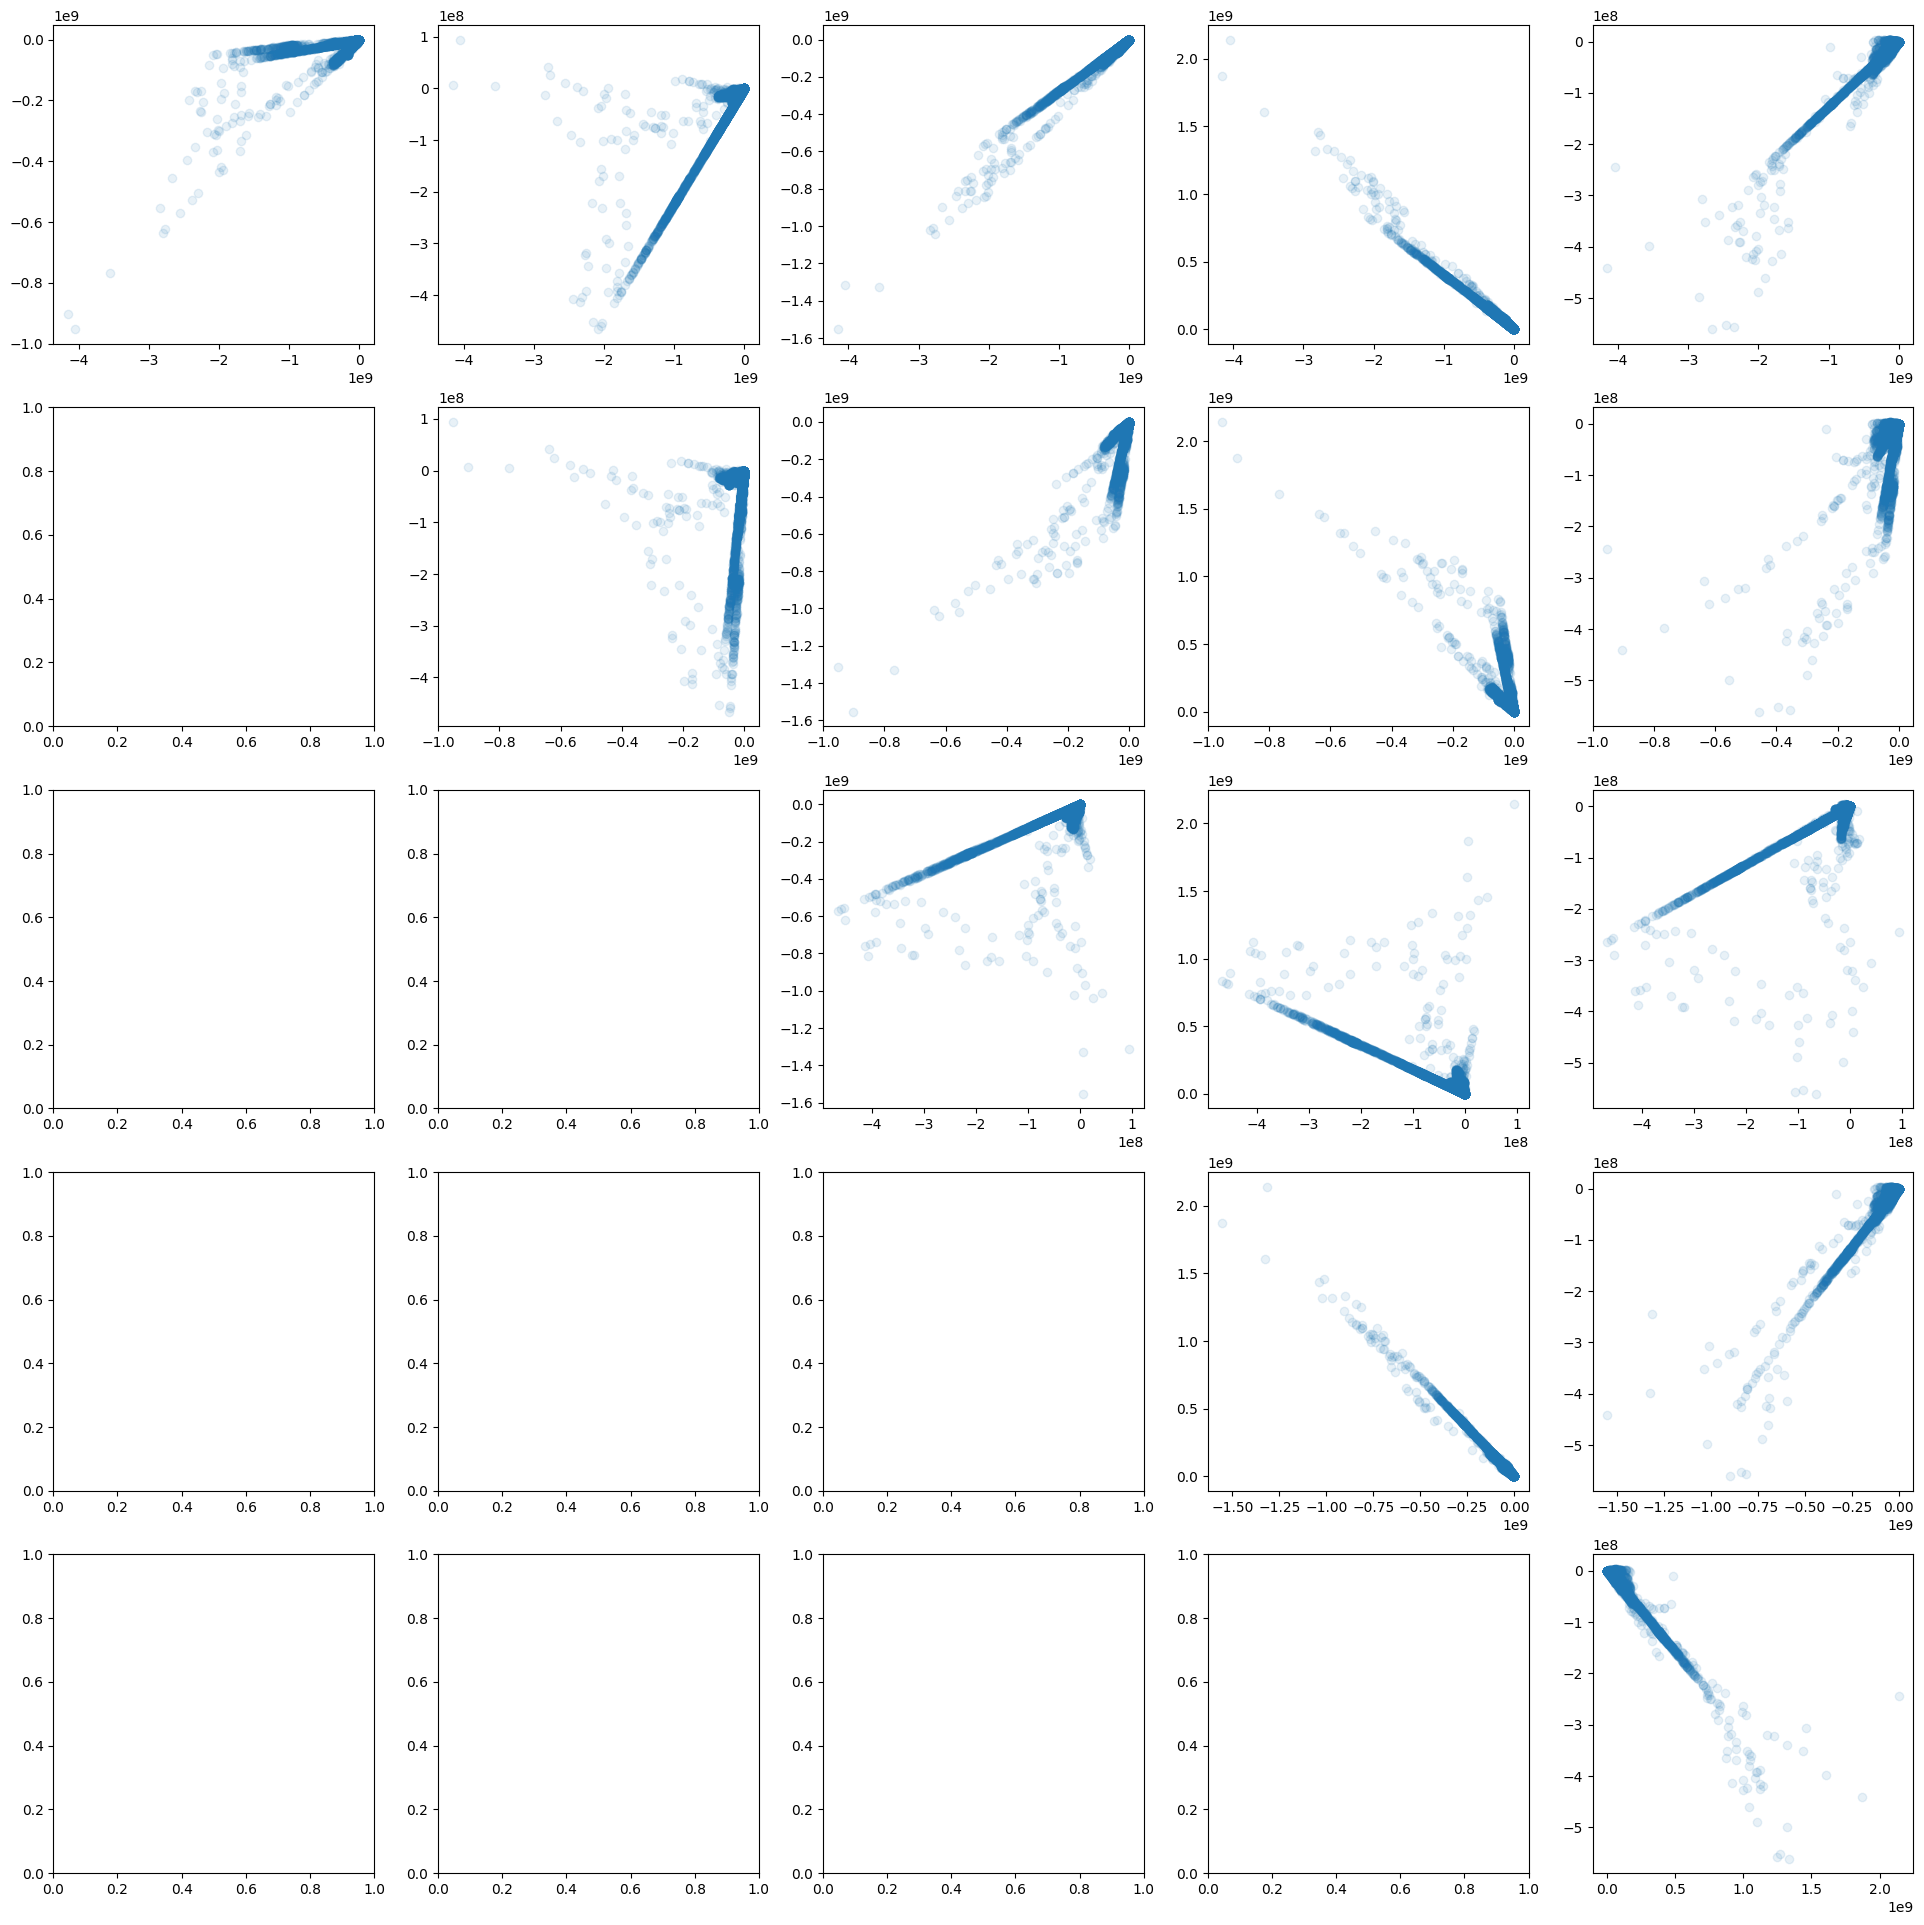

In [12]:
fib, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 24))
for i in range(5):
    for j in range(1, 6):
        if i>= j:
            continue
        axs[i][j-1].scatter(monp["x"][:, i], monp["x"][:, j], alpha=0.1)

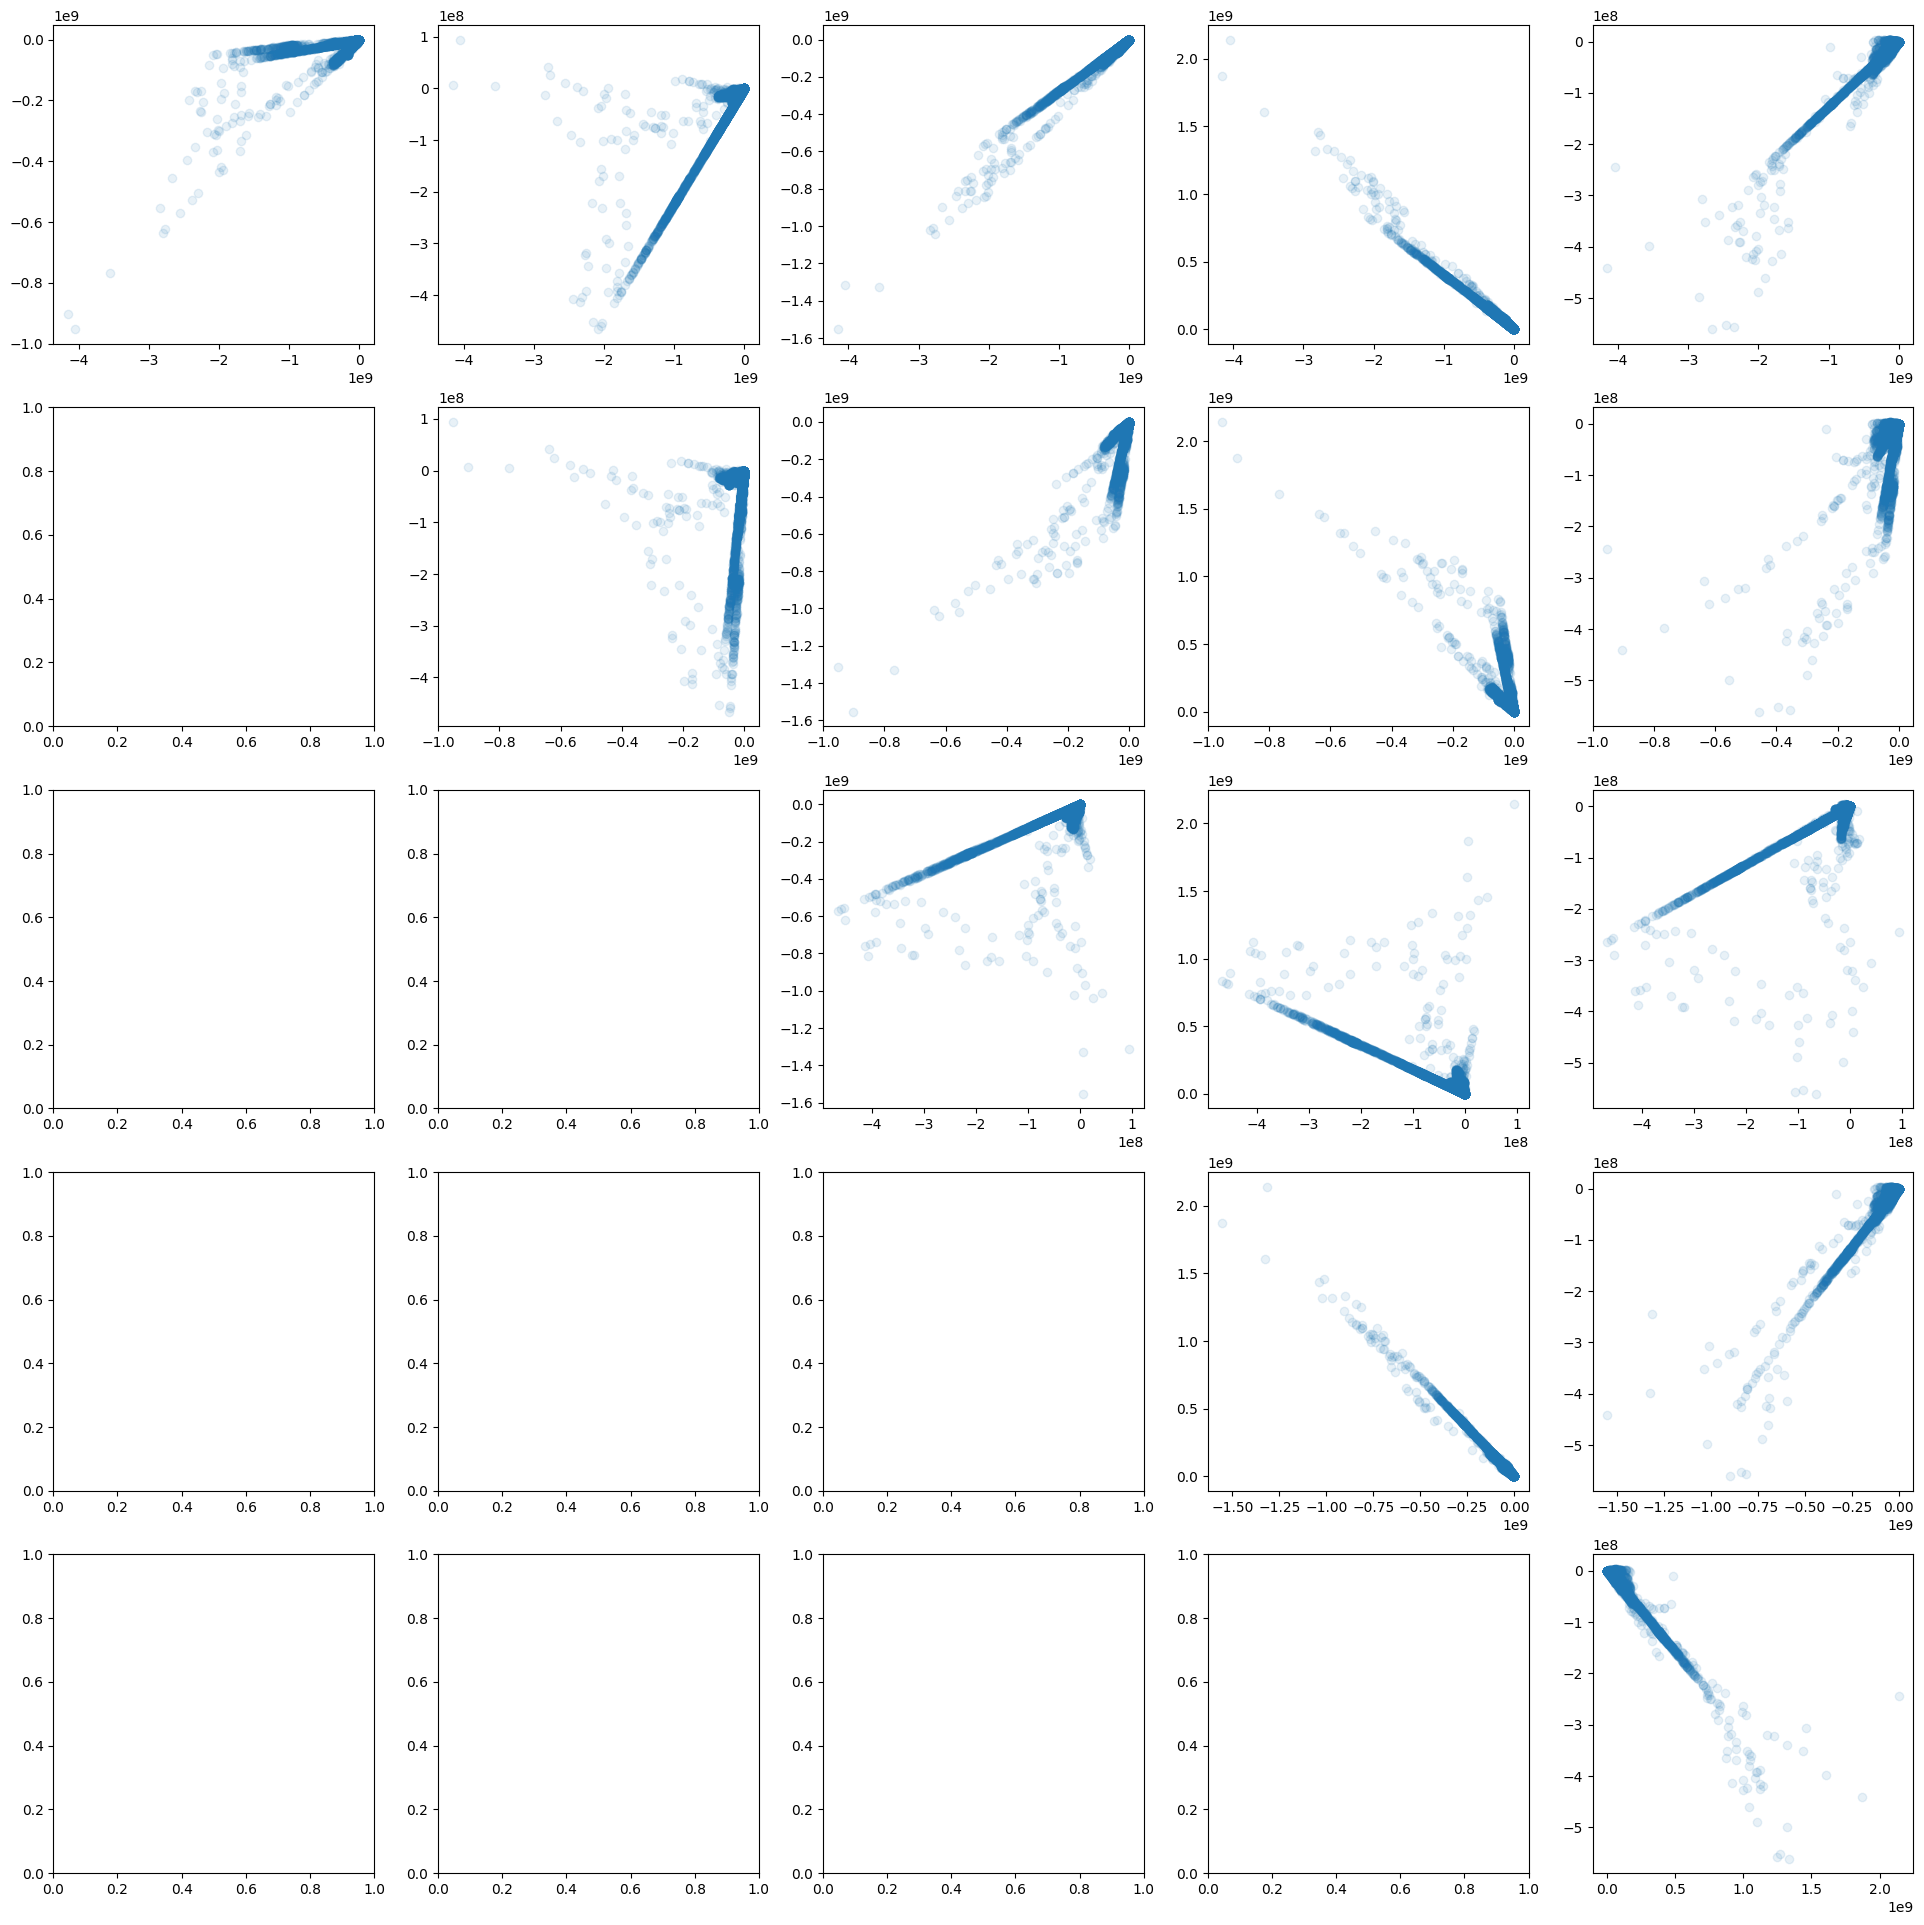

In [13]:
fib, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 24))
for i in range(5):
    for j in range(1, 6):
        if i>= j:
            continue
        axs[i][j-1].scatter(mo["x"][:, i], mo["x"][:, j], alpha=0.1)

In [21]:
mask = mo["particle_id"][mo["ec_hit_mask"]] == mo["particle_id"][mo["ec_hit_mask"]][10]

In [22]:
from gnn_tracking.postprocessing.dbscanscanner import dbscan

labels = dbscan(mo["x"].detach().numpy(), eps=0.9)

In [ ]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics

m = mo["ec_hit_mask"]
tracking_metrics(
    truth=mo["y"][m],
    predicted=labels,
    pts=mo["pt"][m],
    reconstructable=mo["reconstructable"][m],
    pt_thlds=[0.9]
)